In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as tick

import sys
sys.path.insert(0, '../..')

from RB_ZTF.scripts.rnn import *
from RB_ZTF.scripts.datasets import *

In [2]:
set_random_seed(7)

# Plot distribution of images number per object

In [3]:
def check_if_r(oid):
    if len(oid) != 15:
        return True if bands[oid[4]]=='r' else False
    else:
        return True if bands[oid[3]]=='r' else False

In [8]:
oid_list = os.listdir('../data')
bands = {'1':'g', '2':'r', '3':'i'}

fits_count = []
r_oid_list = []
for oid in oid_list:
    if check_if_r(oid):
        fits_list = os.listdir(f'../data/{oid}')
        fits_count.append(len(fits_list))
        r_oid_list.append(oid)

r_oid_list = np.array(r_oid_list)
fits_count = np.array(fits_count)


bucket_boundaries = [200, 400, 600, 800]

In [9]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=6, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=3, width=1.5)
    ax.xaxis.set_major_locator(tick.MultipleLocator(200))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(100))
    #ax.yaxis.set_major_locator(tick.MultipleLocator(0.0005))

Text(0, 0.5, 'Object number')

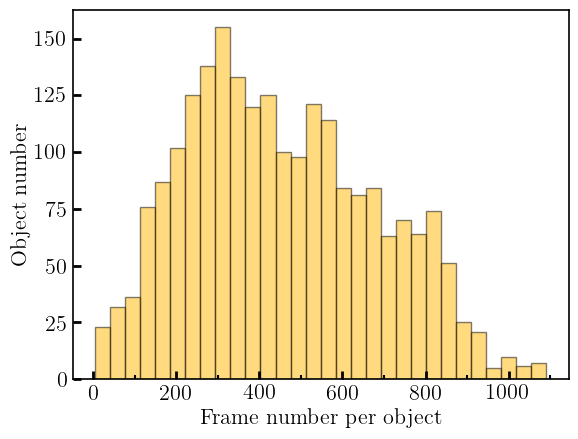

In [11]:
fig, ax = plt.subplots()
plt.hist(fits_count, bins=30, color='#FFB700', edgecolor='black', alpha=0.5)
plt.xlabel('Frame number per object')
presets_fig(ax)
plt.ylabel('Object number')
#plt.savefig('visualizations/seq_hist_simple.pdf', dpi=400, format='pdf')

# VAE LOSS plot

In [14]:
losses = np.load('../trained_models/vae/loss.npy', allow_pickle='TRUE')
losses_aug = np.load('../trained_models/vae/loss_aug.npy', allow_pickle='TRUE')
losses_78 = np.load('../trained_models/vae/loss_ld78.npy', allow_pickle='TRUE')

In [15]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)

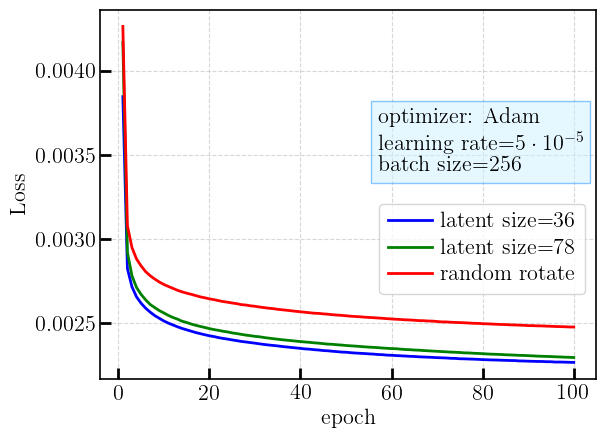

In [18]:
fig, ax = plt.subplots()
presets_fig(ax)
ax.plot(np.arange(1, len(losses)+1), losses, c='blue', label='latent size=36')
ax.plot(np.arange(1, len(losses_78)+1), losses_78, c='green', label='latent size=78')
ax.plot(np.arange(1, len(losses_aug)+1), losses_aug, c='red', label='random rotate')

ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.grid('on', linestyle='--', alpha=0.5)
plt.text(57, 0.0034, 'optimizer: Adam\n' + r'learning rate=$5 \cdot 10^{-5}$' + '\nbatch size=256',
        bbox={"facecolor": '#CDF0FF',
                   "boxstyle": "square",
                   "edgecolor": "#1E90FF",
             "alpha":0.5})

ax.legend(loc='lower right', columnspacing=0.7, labelspacing=0.3,
               handletextpad=0.35, bbox_to_anchor=(1,0.2))

#plt.savefig('visualizations/vae_loss.pdf', dpi=400, format='pdf', bbox_inches="tight")

# Plot examples of artefacts

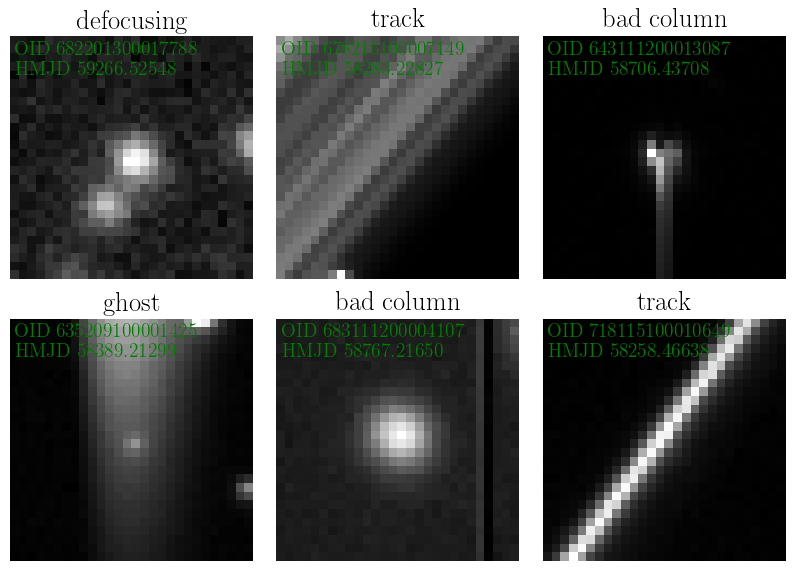

In [19]:
art_name = ['defocusing', 'track', 'ghost', 'column', 'track2', 'column2']
oids = [682201300017788, 678216100007149, 635209100001425, 683111200004107, 718115100010649, 643111200013087]
hmjds = [59266.52548306761, 58283.22827018332, 58389.2129856525, 58767.21649809042, 58258.466378265526, 58706.43707652902]
fig, axs = plt.subplot_mosaic([['defocusing', 'track', 'column2'],
                               ['ghost', 'column', 'track2']], figsize=(10, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
cool = {'defocusing':'defocusing', 'track':'track', 'track2':'track', 'column':'bad column',
       'column2':'bad column', 'ghost':'ghost'}
for i, bogus in enumerate(art_name):
    img = np.load(f'../visualizations/artefact_img/{bogus}.npy')
    axs[bogus].imshow(img, cmap='gray')
    axs[bogus].axis('off')
    axs[bogus].set_title(cool[bogus])
    axs[bogus].text(0.1, 4, f'OID {oids[i]} \n HMJD {hmjds[i]:.5f}',
         color='green', fontsize=14
        )
#plt.savefig('../visualizations/artfs.pdf', dpi=400, format='pdf', bbox_inches="tight")

# Recurrent neural networks


## ROC-AUC vs epoch (average curves for different models)

In [3]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)
    ax.xaxis.set_major_locator(tick.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(50))
    ax.yaxis.set_minor_locator(tick.MultipleLocator(0.05))

Text(0, 0.5, 'ROC-AUC')

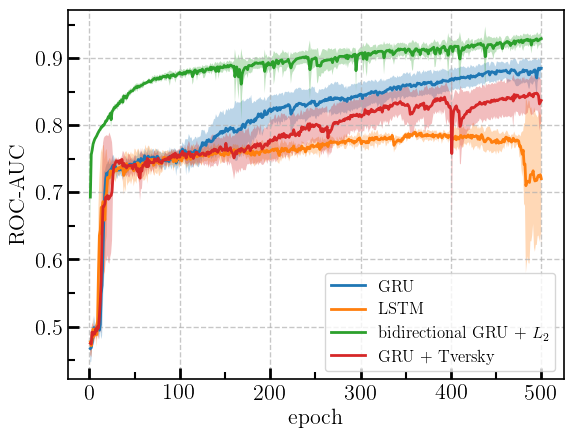

In [12]:
models = ['baseline', 'lstm', 'wd_2dir', 'tversky']
cool_names = ['GRU', 'LSTM', 'bidirectional GRU $+~L_2$', 'GRU $+$ Tversky']

fig, ax = plt.subplots()
presets_fig(ax)
for mod, name in zip(models,cool_names):
    values = []
    for i in range(5):
        result = np.load(f'../trained_models/rnn/{mod}/result{i}.npy', allow_pickle=True)
        roc_auc = []
        for k in range(500):
            roc_auc += result[k]['train_roc_auc']
        values.append(roc_auc)
    values = np.array(values)
    ax.plot(np.arange(1, 501), np.mean(values, axis=0), label=name)
    ax.fill_between(np.arange(1, 501),
                        np.mean(values, axis=0) + np.std(values, axis=0),
                        np.mean(values, axis=0) - np.std(values, axis=0),
                        alpha=0.3)
ax.grid('on', linestyle='--', alpha=0.7, linewidth=1)
ax.legend(fontsize=12)
ax.set_xlabel('epoch')
ax.set_ylabel('ROC-AUC')

#plt.savefig('../visualizations/roc_auc.pdf', dpi=400, format='pdf', bbox_inches="tight")

## Loss vs epoch (average curves for different models)

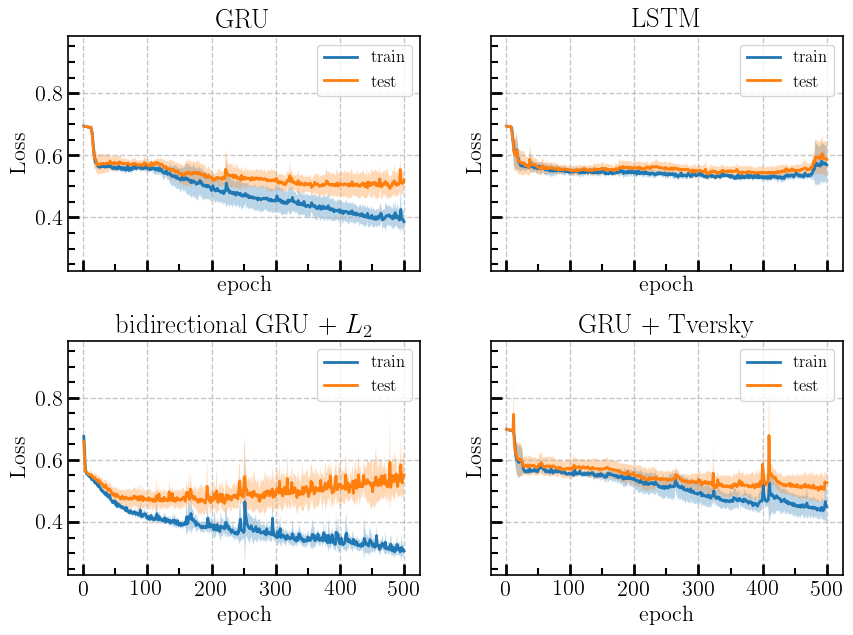

In [13]:
models = ['baseline', 'lstm', 'wd_2dir', 'tversky']
cool_names = ['GRU', 'LSTM', 'bidirectional GRU $+~L_2$', 'GRU $+$ Tversky']

fig, axs = plt.subplot_mosaic([['baseline', 'lstm'], ['wd_2dir', 'tversky']], sharex=True, sharey=True, figsize=(10, 7))
for mod, name in zip(models, cool_names):
    presets_fig(axs[mod])
    test_values, train_values = [], []
    for i in range(5):
        result = np.load(f'../trained_models/rnn/{mod}/result{i}.npy', allow_pickle=True)
        train_loss, test_loss = [], []
        for k in range(500):
            train_loss += result[k]['train_loss']
            test_loss += result[k]['test_loss']
        test_values.append(test_loss)
        train_values.append(train_loss)

        
    test_values, train_values = np.array(test_values), np.array(train_values)
    axs[mod].plot(np.arange(1, 501), np.mean(train_values, axis=0), label='train')
    axs[mod].fill_between(np.arange(1, 501),
                        np.mean(train_values, axis=0) + np.std(train_values, axis=0),
                        np.mean(train_values, axis=0) - np.std(train_values, axis=0),
                        alpha=0.3)

    axs[mod].plot(np.arange(1, 501), np.mean(test_values, axis=0), label='test')
    axs[mod].fill_between(np.arange(1, 501),
                        np.mean(test_values, axis=0) + np.std(test_values, axis=0),
                        np.mean(test_values, axis=0) - np.std(test_values, axis=0),
                        alpha=0.3)
    
    axs[mod].grid('on', linestyle='--', alpha=0.7, linewidth=1)
    axs[mod].legend(fontsize=12)
    axs[mod].set_xlabel('epoch')
    axs[mod].set_ylabel('Loss')
    axs[mod].set_title(name)

fig.subplots_adjust(hspace=0.3)
#plt.savefig('../visualizations/rnn_losses.pdf', dpi=400, format='pdf', bbox_inches="tight")